In [2]:
import numpy as np
import os
from pImpactR import MLI as mli
from pImpactR import opt
from pImpactR.util import Me
from copy import deepcopy as copy
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
nturn = 2048
npt = 64
std = 0.1
Espread = 2.0e-3
OnEnergy = False

# Read MLI input for settings

In [4]:
elems,latticeList,labor = mli.readInputfile('mli.in.t3_iota_8_4_t0p4')
elems[2].driftexact=1
elems,latticeList=mli.sext2thin(elems,latticeList,brho=0.50204778184582999)
latticeList = [latticeList[0]]

setarclen is not recognized. skipping...
autoconcat is not recognized. skipping...
autoapply is not recognized. skipping...
reftraj is not recognized. skipping...
fit is not recognized. skipping...
bip is not recognized. skipping...
tip is not recognized. skipping...


In [5]:
elemList = []
for item in elems:
    if not item.elem in ['tasm','aim','vary','anaprint','monitor']:
        elemList.append(item)

In [6]:
energy=elems[0].energy*1.0e9
gam0 = energy/Me
bet0 = np.sqrt(1.0-1.0/gam0**2)

In [7]:
NL_nu = 0.3
NL_L  = 1.8
NL_c  = 0.01
NL_t  = 0.4
alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)
k = 2*alfx/betx

f3 = k/(2*bet0)
f4 = k/(2*bet0*gam0)**2
print(bet0,k,f3,f4)

0.99999423665409 1.4544633270832747 0.727235854853427 4.191323867725334e-06


In [8]:
def MLI2norm(data_in,sign=1):
    data=data_in.copy()
    data[:,5] = np.sqrt(1.0-2.0*data[:,5]/bet0+data[:,5]**2)-1.0
    data[:,1] = (data[:,0]*alfx*sign/np.sqrt(betx) + data[:,1]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx*sign/np.sqrt(betx) + data[:,3]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    return data
    
def norm2MLI(data_in,sign=1):
    data=data_in.copy()
    data[:,1] = (-data[:,0]*alfx*sign + data[:,1])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,3] = (-data[:,2]*alfx*sign + data[:,3])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c
    data[:,5] = -np.sqrt((1.0+data[:,5])**2+1.0/(bet0*gam0)**2)+1.0/bet0
    return data

In [9]:
# from scipy.stats import truncnorm

# def get_truncated_normal(mean=0, sd=1, low=0, upp=10,n=1):
#     f = truncnorm(
#         (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
#     return f.rvs(n)

In [10]:
# pData0 = np.load('pDataNorm.npy')
# pDataIn = norm2MLI(pData0,sign=1)
# np.savetxt('rays.in',pDataIn)

In [11]:
# x=get_truncated_normal(sd=std,low=-2.0*std,upp=2.0*std,n=npt*5)
# pData=np.zeros([npt,6])
# pData[:,[0,1,2,3,5]]=x.reshape([npt,5])
# pData[:,5] = pData[:,5]/std*Espread
# np.save('pDataNorm.std=0.1',pData)
pData = np.load('pDataNorm.std=0.1.npy')
if OnEnergy:
    pData[:,5] = 0.0

pDataIn = norm2MLI(pData,sign=1)
np.savetxt('rays.in',pDataIn)

# Cmds

In [12]:
raysin  =mli.getElem.raytrace(file1='rays.in',type='readonly')
dump    =mli.getElem.particledump(file='rays.out',precision=15)
track   =mli.getElem.autotrack(type='symplectic',order=5)
fin     =mli.getElem.fin

elemList = elemList + [raysin, dump, track, fin]

# Lattice

In [13]:
nlinsert=mli.getElem.nlinsert()

iotaline = latticeList[0]
arc = copy(iotaline)
arc.name = 'arc'
iotaline.list.insert(0,nlinsert.name)
iotaline.list.append(dump.name)

elemList = elemList + [nlinsert]

In [14]:
indexThin = []
for i,item in enumerate(elemList):
    if 'thlm' == item.elem:
        indexThin.append(i)
nThin = len(indexThin)
print(nThin)

18


# Labor

In [15]:
maplabor = mli.buildLabor(['arc','mapout'])

#  Run

In [16]:
def getTBT(npt,nturn,fname='rays.out'):
    TBT = np.loadtxt(fname)
    TBT = TBT[:npt*nturn,:6]
    out = np.zeros([npt,nturn,6])
    for i in range(nturn):
        out[:,i,:] = TBT[i*npt:(i+1)*npt,:]
        out[:,i,:] = MLI2norm(out[:,i,:])
    return out

In [17]:
def updateStrength(arg):
    for i,j in enumerate(indexThin):
        elemList[j]['k2l']=arg[i]
    for i,j in enumerate(indexThin):
        elemList[j]['k3l']=arg[i+nThin]

In [18]:
import pickle
with open('result.thin.sext.oct','rb') as fp:
    result=pickle.load(fp)

In [19]:
mli.writeInputfile(elemList,[arc],maplabor)
mli.run()
M,G=mli.readTransferMap()

In [20]:
G

,exponents,GP
28,f( 30 00 00 ),-2.355553e+01
29,f( 21 00 00 ),-6.288173e+01
33,f( 20 00 01 ),2.119149e+01
34,f( 12 00 00 ),-5.164333e+01
38,f( 11 00 01 ),5.472919e+01
39,f( 10 20 00 ),-1.618717e+01
40,f( 10 11 00 ),2.365113e+01
43,f( 10 02 00 ),2.411779e+01
48,f( 10 00 02 ),-6.887282e+01
49,f( 03 00 00 ),-1.851668e+01


In [19]:
elemList = elemList[:3] + elemList[-6:]

In [20]:
Gref = copy(G)
Gref['GP'] = 0
Gref.loc[33,'GP'] = 0.5*k/bet0
Gref.loc[67,'GP'] = 0.5*k/bet0
Gref.loc[104,'GP'] = k/(2.0*bet0*gam0)**2
Gref.loc[184,'GP'] = k/(2.0*bet0*gam0)**2

In [21]:
Gtmp = copy(G)
Gtmp.loc[462:910,'GP']=Gref.loc[462:910,'GP']

In [22]:
readmap = mli.getElem.tmi(name='readmap')
readmap.map2file(M,Gtmp)
savemap = mli.getElem.stm(name='savemap')
getmap    = mli.getElem.gtm(name='getmap')
elemList = elemList + [readmap,savemap,getmap]
iotaline.list=[iotaline.list[0],'getmap',iotaline.list[-1]]
labor = mli.buildLabor(['readmap','savemap','getmap','clear',raysin.name,track.name,str(nturn)+'*'+iotaline.name,'fin'])
mli.writeInputfile(elemList,latticeList,labor)
mli.run(8)
TBT6 = getTBT(npt,nturn)
print(TBT6.shape)

(64, 2048, 6)


In [23]:
Gtmp = copy(G)
Gtmp.loc[210:450,'GP'] = Gref.loc[210:450,'GP']
Gtmp.loc[462:910,'GP'] = Gref.loc[462:910,'GP']
readmap.map2file(M,Gtmp)
mli.run(8)
TBT56 = getTBT(npt,nturn)
print(TBT56.shape)

(64, 2048, 6)


In [24]:
Gtmp = copy(G)
Gtmp.loc[84 :200,'GP'] = Gref.loc[84 :200,'GP']
Gtmp.loc[210:450,'GP'] = Gref.loc[210:450,'GP']
Gtmp.loc[462:910,'GP'] = Gref.loc[462:910,'GP']
readmap.map2file(M,Gtmp)
mli.run(8)
TBT456 = getTBT(npt,nturn)
print(TBT456.shape)

(64, 2048, 6)


In [25]:
Gtmp = copy(G)
Gtmp.loc[28 :76 ,'GP'] = Gref.loc[28 :76 ,'GP']
readmap.map2file(M,Gtmp)
mli.run(8)
TBT3 = getTBT(npt,nturn)
print(TBT3.shape)

(64, 2048, 6)


In [26]:
Gtmp = copy(G)
Gtmp.loc[28 :76 ,'GP'] = Gref.loc[28 :76 ,'GP']
Gtmp.loc[210:450,'GP'] = Gref.loc[210:450,'GP']
readmap.map2file(M,Gtmp)
mli.run(8)
TBT34 = getTBT(npt,nturn)
print(TBT34.shape)

(64, 2048, 6)


In [28]:
Gtmp = copy(G)
Gtmp.loc[210:450,'GP'] = Gref.loc[210:450,'GP']
readmap.map2file(M,Gtmp)
mli.run(8)
TBT4 = getTBT(npt,nturn)
print(TBT4.shape)

(64, 2048, 6)


#### Check invariants

In [27]:
def getInv(xn,pxn,yn,pyn,delta,tau=NL_t):
    z = xn + 1j*yn
    U = np.real(z/np.sqrt(1-z**2)*np.arcsin(z))
    W = np.real(2*xn/np.sqrt(1-z**2)*np.arcsin(z))
    Hn = 0.5*(xn**2+pxn**2+yn**2+pyn**2)   +tau*U/(1.0+delta)
    In = (xn*pyn -yn*pxn)**2 +xn**2+pxn**2 +tau*W/(1.0+delta)
    return Hn,In

def getInvTBT(TBT):
    npt,nturn,dummy = TBT.shape
    InvTBT = np.zeros([npt,nturn,2])
    for iturn in range(nturn):
        data = TBT[:,iturn,:]
        for ipt in range(npt):
            xn    = data[ipt,0]
            pxn   = data[ipt,1]
            yn    = data[ipt,2]
            pyn   = data[ipt,3]
            delta = data[ipt,5]
            InvTBT[ipt,iturn,:] = getInv(xn,pxn,yn,pyn,delta)
    return InvTBT

In [30]:
Inv3 = getInvTBT(TBT3)
Inv4 = getInvTBT(TBT4)
Inv34 = getInvTBT(TBT34)
Inv6 = getInvTBT(TBT6)
Inv56 = getInvTBT(TBT56)
Inv456 = getInvTBT(TBT456)

### Absolute

In [31]:
print('--max invarinats--')
print(np.max(Inv3[:,:,0]),np.max(Inv3[:,:,1]))
print(np.max(Inv4[:,:,0]),np.max(Inv4[:,:,1]))
print(np.max(Inv34[:,:,0]),np.max(Inv34[:,:,1]))
print(np.max(Inv6[:,:,0]),np.max(Inv6[:,:,1]))
print(np.max(Inv56[:,:,0]),np.max(Inv56[:,:,1]))
print(np.max(Inv456[:,:,0]),np.max(Inv456[:,:,1]))

--max invarinats--
0.057249372194527436 0.09879368334711874
nan nan
0.056988855452484014 0.09810661912600388
nan nan
nan nan
nan nan


In [32]:
amp3 = np.zeros([npt,2])
amp4 = np.zeros([npt,2])
amp34 = np.zeros([npt,2])
amp6 = np.zeros([npt,2])
amp56 = np.zeros([npt,2])
amp456 = np.zeros([npt,2])
for i in range(npt):
    amp3[i,0] = np.std(Inv3[i,:,0])
    amp3[i,1] = np.std(Inv3[i,:,1])
    amp4[i,0] = np.std(Inv4[i,:,0])
    amp4[i,1] = np.std(Inv4[i,:,1])
    amp34[i,0] = np.std(Inv34[i,:,0])
    amp34[i,1] = np.std(Inv34[i,:,1])
    amp6[i,0] = np.std(Inv6[i,:,0])
    amp6[i,1] = np.std(Inv6[i,:,1])
    amp56[i,0] = np.std(Inv56[i,:,0])
    amp56[i,1] = np.std(Inv56[i,:,1])
    amp456[i,0] = np.std(Inv456[i,:,0])
    amp456[i,1] = np.std(Inv456[i,:,1])
print('--mean of amplitudes--')
print(amp3[:,0].mean(),amp3[:,1].mean())
print(amp4[:,0].mean(),amp4[:,1].mean())
print(amp34[:,0].mean(),amp34[:,1].mean())
print(amp6[:,0].mean(),amp6[:,1].mean())
print(amp56[:,0].mean(),amp56[:,1].mean())
print(amp456[:,0].mean(),amp456[:,1].mean())

--mean of amplitudes--
0.0005405245206464152 0.0010898028069018602
nan nan
0.0005404413145826143 0.001089156605717661
nan nan
nan nan
nan nan


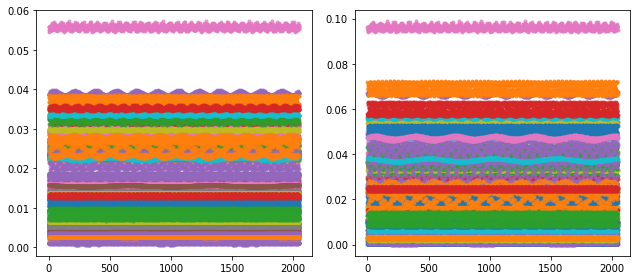

In [33]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv3[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv3[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

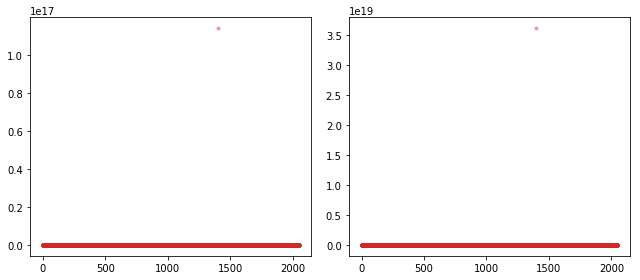

In [34]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv4[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv4[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

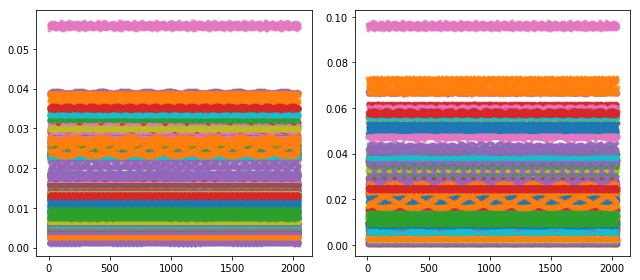

In [35]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv34[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv34[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

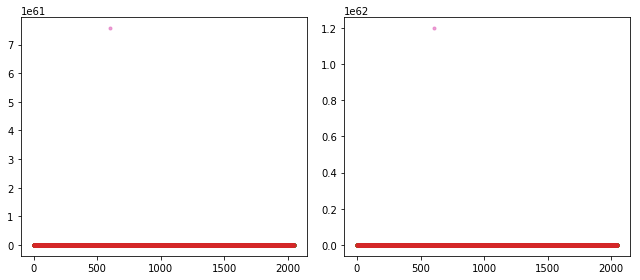

In [36]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv6[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv6[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

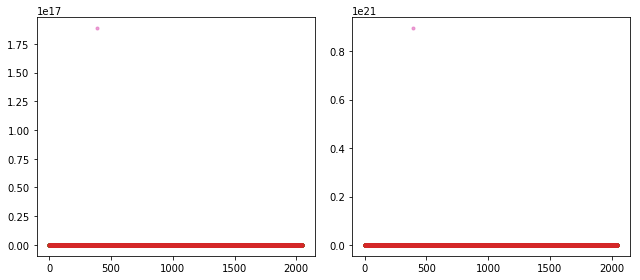

In [37]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv56[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv56[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

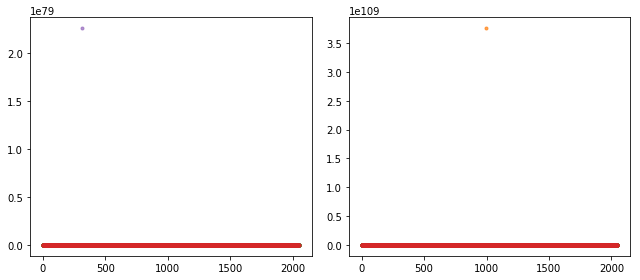

In [38]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv456[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv456[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

### Relative

In [39]:
for i in range(npt):
    Inv3[i,:,0] = Inv3[i,:,0]/Inv3[i,0,0].mean()-1.0
    Inv3[i,:,1] = Inv3[i,:,1]/Inv3[i,0,1].mean()-1.0
    Inv4[i,:,0] = Inv4[i,:,0]/Inv4[i,0,0].mean()-1.0
    Inv4[i,:,1] = Inv4[i,:,1]/Inv4[i,0,1].mean()-1.0
    Inv34[i,:,0] = Inv34[i,:,0]/Inv34[i,0,0].mean()-1.0
    Inv34[i,:,1] = Inv34[i,:,1]/Inv34[i,0,1].mean()-1.0
    Inv6[i,:,0] = Inv6[i,:,0]/Inv6[i,0,0].mean()-1.0
    Inv6[i,:,1] = Inv6[i,:,1]/Inv6[i,0,1].mean()-1.0
    Inv56[i,:,0] = Inv56[i,:,0]/Inv56[i,0,0].mean()-1.0
    Inv56[i,:,1] = Inv56[i,:,1]/Inv56[i,0,1].mean()-1.0
    Inv456[i,:,0] = Inv456[i,:,0]/Inv456[i,0,0].mean()-1.0
    Inv456[i,:,1] = Inv456[i,:,1]/Inv456[i,0,1].mean()-1.0

In [40]:
print('--max relative invarinats--')
print(np.max(Inv3[:,:,0]),np.max(Inv3[:,:,1]))
print(np.max(Inv4[:,:,0]),np.max(Inv4[:,:,1]))
print(np.max(Inv34[:,:,0]),np.max(Inv34[:,:,1]))
print(np.max(Inv6[:,:,0]),np.max(Inv6[:,:,1]))
print(np.max(Inv56[:,:,0]),np.max(Inv56[:,:,1]))
print(np.max(Inv456[:,:,0]),np.max(Inv456[:,:,1]))

--max relative invarinats--
0.6878496639510234 1.3205905562905103
nan nan
0.5668147163797048 1.0199238601774652
nan nan
nan nan
nan nan


In [41]:
amp3 = np.zeros([npt,2])
amp4 = np.zeros([npt,2])
amp34 = np.zeros([npt,2])
amp6 = np.zeros([npt,2])
amp56 = np.zeros([npt,2])
amp456 = np.zeros([npt,2])
for i in range(npt):
    amp3[i,0] = np.std(Inv3[i,:,0])
    amp3[i,1] = np.std(Inv3[i,:,1])
    amp4[i,0] = np.std(Inv4[i,:,0])
    amp4[i,1] = np.std(Inv4[i,:,1])
    amp34[i,0] = np.std(Inv34[i,:,0])
    amp34[i,1] = np.std(Inv34[i,:,1])
    amp6[i,0] = np.std(Inv6[i,:,0])
    amp6[i,1] = np.std(Inv6[i,:,1])
    amp56[i,0] = np.std(Inv56[i,:,0])
    amp56[i,1] = np.std(Inv56[i,:,1])
    amp456[i,0] = np.std(Inv456[i,:,0])
    amp456[i,1] = np.std(Inv456[i,:,1])
print('--mean of amplitudes--')
print(amp3[:,0].mean(),amp3[:,1].mean())
print(amp4[:,0].mean(),amp4[:,1].mean())
print(amp34[:,0].mean(),amp34[:,1].mean())
print(amp6[:,0].mean(),amp6[:,1].mean())
print(amp56[:,0].mean(),amp56[:,1].mean())
print(amp456[:,0].mean(),amp456[:,1].mean())

--mean of amplitudes--
0.04772013207156851 0.07972835213647035
nan nan
0.0466829093667708 0.07563914539032067
nan nan
nan nan
nan nan


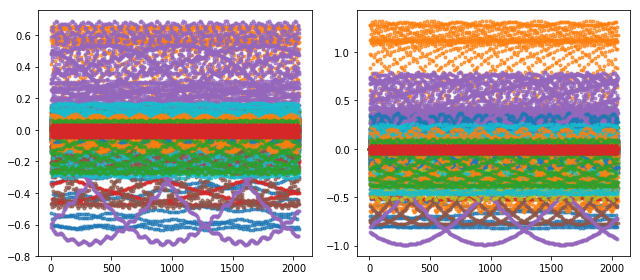

In [42]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv3[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv3[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

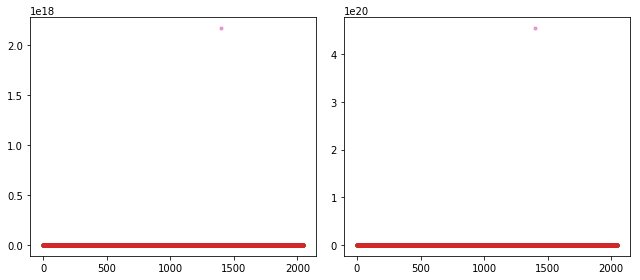

In [43]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv4[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv4[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

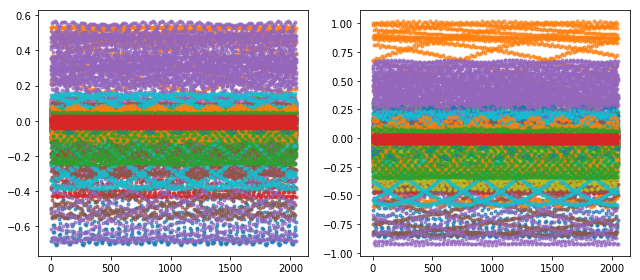

In [44]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv34[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv34[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

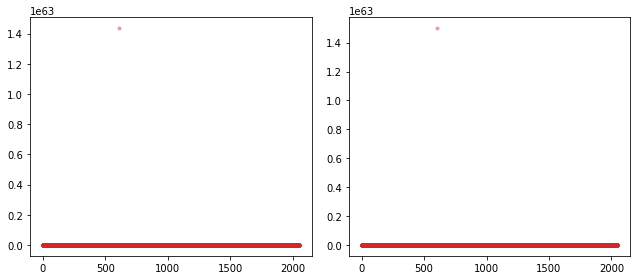

In [45]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv6[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv6[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

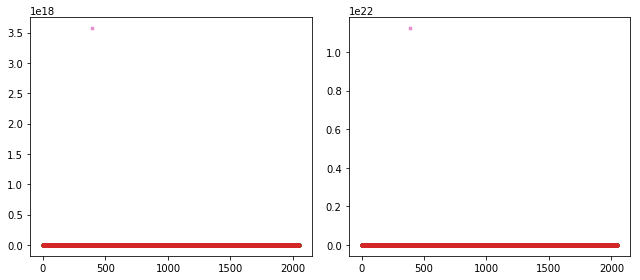

In [46]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv56[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv56[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

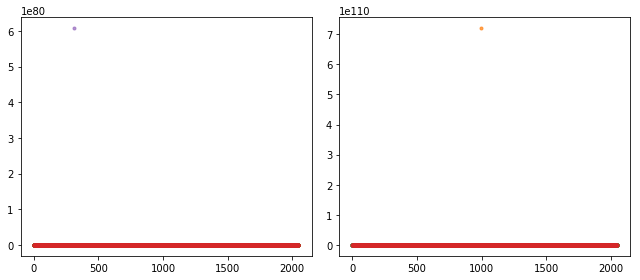

In [47]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv456[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv456[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

In [1]:
G

NameError: name 'G' is not defined